In [456]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 1)

# Building hamiltonian
coeffs = [-0.5]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [457]:
# Global paras 
Paras_global, Phi_global, Gamma_ps  = np.zeros(2), 0, 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

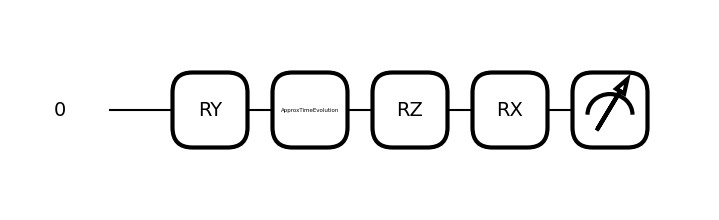

In [458]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global
    phi_z1, theta_x = Paras_global[0], Paras_global[1]

    qml.RY(np.pi/2, wires = 0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)

    qml.RZ(phi_z1, wires = 0)  # phi_z1
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    # qml.RZ(phi_z2, wires = 0)  # phi_z2
    
    return qml.density_matrix(wires = 0)

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

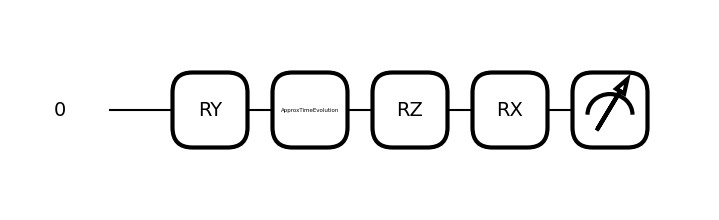

In [459]:
@qml.qnode(dev)
def circuit_explict(phi):
    qml.RY(np.pi/2, wires = 0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    
    qml.RZ(np.pi/2, wires = 0)  # phi_z
    
    qml.RX(np.pi/2, wires = 0)  # theta_x
    
    # qml.RZ(np.pi/2, wires = 0)  # phi_z

    return qml.density_matrix(wires = 0)

paras_plot = 1
fig, ax = qml.draw_mpl(circuit_explict)(paras_plot)

$$
Equivalent \quad to \quad RY(pi/2)?
$$

$$
RY(pi/2)
\quad

TimeEvo(phi)
\quad

RZ(pi/2)
\quad

RX(pi/2)
$$

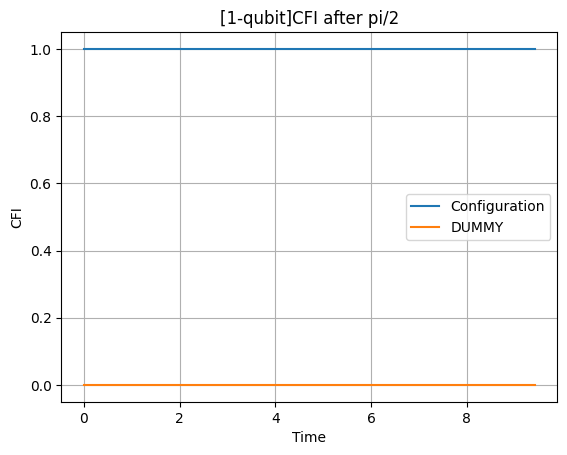

In [460]:
CFI_Data_Explict = np.arange(1e-4, np.pi * 3 + 1e-4, 1e-2)
DATA_Explict = np.zeros(len(CFI_Data_Explict))
DUMMY = np.zeros(len(CFI_Data_Explict))

for i in range(len(CFI_Data_Explict)):
    DATA_Explict[i] = qml.qinfo.classical_fisher(circuit_explict)(CFI_Data_Explict[i])
    
plt.title(f'[1-qubit]CFI after pi/2')
plt.plot(CFI_Data_Explict, DATA_Explict, label = 'Configuration')
plt.plot(CFI_Data_Explict, DUMMY, label = 'DUMMY')

plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

In [461]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(circuit)(phi[0])
    
    return -CFI

In [462]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        Sweep_Data (numpy_array): Range of data sweeps.
        paras (numpy_array): Array of 3 parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        Iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array
    """
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # INDEX CONSTANT
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Before optimization; CFI data
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
        for Paras_Index_Array in range(len(paras)):
            Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
        
    # Optimize begin
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            # Constraints = [(-float('inf'), float('inf'))] * 3
            Constraints = [(0, np.pi)] * 2
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

$$
Data[Layer][Row][Col] = [PHI, \quad CFI, \quad theta_x, \quad phi_z]
$$

In [463]:
# == Sweep for 0 ~ pi*3 == 
Step = 1e-2
Sweep_data = np_.array([1e-4, np.pi * 1 + 1e-4, Step])

Paras_init = np.zeros(2)
Paras_init[:2] = 1.4

Gamma_ps_preset = 1e-6
Set_Iterations = 1

Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)

print(Paras_init)

[1.4 1.4]


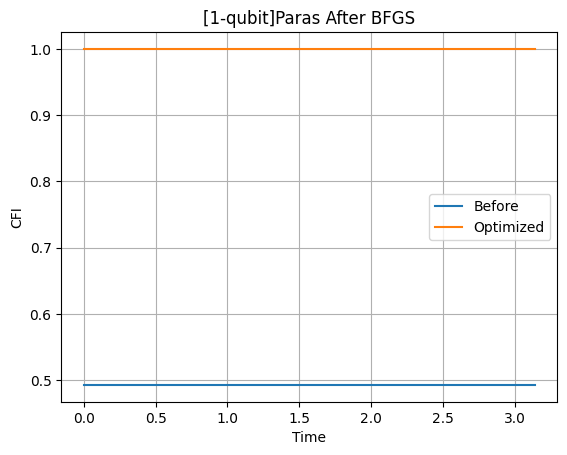

In [464]:
plt.title(f'[1-qubit]Paras After BFGS')

DUMMY = np.zeros(len(Optimized_Result[0][:, 0]))
plt.plot(Optimized_Result[0][:, 0], Optimized_Result[0][:, 1], label = 'Before')
plt.plot(Optimized_Result[0][:, 0], Optimized_Result[1][:, 1], label = 'Optimized')
# plt.plot(Optimized_Result[0][:, 0], DUMMY, label = 'DUMMY')

plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

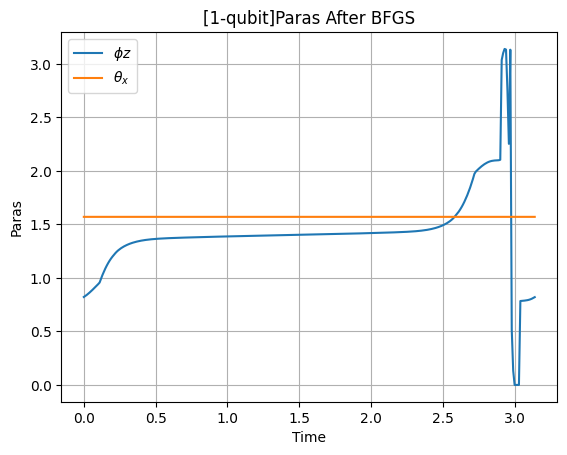

In [465]:
plt.title(f'[1-qubit]Paras After BFGS')

plt.plot(Optimized_Result[0][:, 0], Optimized_Result[1][:, 2], label = r'$\phi{z}$')
# plt.plot(Optimized_Result[0][:, 0], Optimized_Result[1][:, 3], label = r'$\phi{z2}$')
plt.plot(Optimized_Result[0][:, 0], Optimized_Result[1][:, 3], label = r'$\theta_{x}$')

plt.xlabel('Time')
plt.ylabel('Paras')
plt.grid()
plt.legend()

In [466]:
Optimized_Result[1][:, 2]

array([8.21723071e-01, 8.30773503e-01, 8.40777900e-01, 8.51634794e-01,
       8.63232640e-01, 8.75454893e-01, 8.88183823e-01, 9.01304458e-01,
       9.14707106e-01, 9.28289303e-01, 9.41957841e-01, 9.57030957e-01,
       9.93961145e-01, 1.02814251e+00, 1.05974177e+00, 1.08888099e+00,
       1.11563730e+00, 1.14006142e+00, 1.16220327e+00, 1.18213804e+00,
       1.19997924e+00, 1.21593221e+00, 1.23213417e+00, 1.24609699e+00,
       1.25825913e+00, 1.26897064e+00, 1.27850324e+00, 1.28706212e+00,
       1.29480105e+00, 1.30183305e+00, 1.30824296e+00, 1.31409583e+00,
       1.31944378e+00, 1.32433024e+00, 1.32879374e+00, 1.33286864e+00,
       1.33658704e+00, 1.33997864e+00, 1.34307167e+00, 1.34589216e+00,
       1.34846465e+00, 1.35081183e+00, 1.35295440e+00, 1.35491183e+00,
       1.35670167e+00, 1.35834004e+00, 1.35984163e+00, 1.36121996e+00,
       1.36248702e+00, 1.36365415e+00, 1.36473124e+00, 1.36572755e+00,
       1.36665145e+00, 1.36751053e+00, 1.36831179e+00, 1.36906130e+00,
      

In [467]:
Optimized_Result[1][:, 3]

array([1.57079591, 1.57079615, 1.57079626, 1.57079633, 1.57079634,
       1.57079632, 1.57079632, 1.57079632, 1.57079628, 1.57079616,
       1.57079591, 1.57079549, 1.5707947 , 1.57079633, 1.57079631,
       1.57079632, 1.57079633, 1.57079632, 1.57079631, 1.57079632,
       1.57079632, 1.57079547, 1.57079603, 1.57079624, 1.57079631,
       1.57079631, 1.57079633, 1.57079692, 1.57079649, 1.57079636,
       1.57079634, 1.57079632, 1.57079633, 1.57079705, 1.57079657,
       1.57079641, 1.57079634, 1.57079632, 1.57079632, 1.57079632,
       1.57079537, 1.57079618, 1.57079642, 1.57079642, 1.57079638,
       1.57079635, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079632, 1.57079631, 1.57079629, 1.57079626, 1.57079629,
       1.57079623, 1.57079624, 1.57079624, 1.57079622, 1.57079623,
       1.57079624, 1.57079625, 1.57079627, 1.57079627, 1.57079626,
       1.57079626, 1.57079626, 1.57079627, 1.57079628, 1.57079627,
       1.5707963 , 1.5707963 , 1.5707963 , 1.57079633, 1.57079

In [468]:
Optimized_Result[1][:, 4]

IndexError: index 4 is out of bounds for axis 1 with size 4